# Práctica 11. Árboles de Decisión

### Grupo 41
Alumnos:
- Óscar Rico Rodríguez
- Jia Hao Yang

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

### Ejercicio 1: Clasificación de células
Los árboles de decisión al igual que los modelos de clasificación y regresión vistos en las prácticas anteriores, también están implementados en la librería sklearn [14]. La clase que implementa el clasificador por árboles de decisión es DecisionTreeClassifier y se encuentra en el módulo tree, y tiene los métodos están fit y predict ya vistos anteriormente.

El número de parámetros de la clase es bastante amplio y controlan muchos aspectos del comportamiento del modelo. Podemos destacar entre ellos criterion que es la medida de impureza utilizada para determinar qué característica se selecciona en cada nodo y puede ser gini, entropy o log_loss dependiendo si se usa el índice de Gini [3] o la ganancia de información [11]. Otro parámetro es splitter que indica cómo se selecciona la característica una vez se ha  calculado la medida de impureza. Puede tener el valor best para seleccionar la característica con mejor valor de la medida, o random que selecciona una característica de forma aleatoria pero manteniendo la distribución de probabilidad dada por la medida de impureza (características con mejor valor de la medida de impureza tienen mayor probabilidad de ser elegidas). La profundidad máxima del árbol generado se controla mediante el parámetro max_depth. También se puede definir el número de características se consideran en cada nodo con el parámetro max_features. 

El módulo tree implementa la función plot_tree que muestra gráficamente la estructura de un árbol de la clase DecisionTreeClassifier.

En este ejercicio se realizará:
1. Dividir el conjunto de datos en entrenamiento y test.
2. Entrenar un árbol de decisión con los parámetros de la clase por defecto y evaluar su rendimiento.
3. Buscar la mejor combinación en cuanto a profundidad máxima y criterio de división teniendo en cuenta la naturaleza del problema que es un diagnóstico médico.
4. Mostrar gráficamente los árboles obtenidos en el punto 2 y 3 y compararlos.



In [88]:
# Cargar el dataset
df = pd.read_csv('./wisconsin diagnostic breast cancer.csv')

##### 1. Dividir el conjunto de datos en entrenamiento y test.

In [89]:
# Dividimos el dataset en train y test
X = df.loc[:, df.columns != 'Diagnosis'].values
Y = df['Diagnosis'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size= 0.2, random_state=66)

##### 2. Entrenar un árbol de decisión con los parámetros de la clase por defecto y evaluar su rendimiento.

In [90]:
# Creamos el modelo
tree = DecisionTreeClassifier(random_state=7)

# Entrenamos el modelo
tree.fit(X_train, y_train)

# Predecimos los valores de test
y_hat = tree.predict(X_test)

# Evaluar el rendimiento del modelo
acc = accuracy_score(y_test, y_hat)
acc2 = cross_val_score(tree, X, Y, cv=10).mean()
print(f"Accuracy del modelo por defecto: {acc:.3f}")
print(f"Accuracy del modelo con validación cruzada: {acc2:.3f}")

Accuracy del modelo por defecto: 0.930
Accuracy del modelo con validación cruzada: 0.909


##### 3. Buscar la mejor combinación en cuanto a profundidad máxima y criterio de división teniendo en cuenta la naturaleza del problema que es un diagnóstico médico.

In [91]:
# Definir los valores de los parámetros a explorar
param_grid = {
    'max_depth': range(1, 10),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
}

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=7), param_grid=param_grid, scoring='recall', cv=10)
y_train_bool = y_train == 'M'
# Entrenar el objeto GridSearchCV
grid_search.fit(X_train, y_train_bool)


# Obtener los mejores parámetros y la accuracy correspondiente
best_params = grid_search.best_params_
best_acc = grid_search.best_score_

print(f"Mejores parámetros: {best_params}")
print(f"Accuracy con los mejores parámetros: {best_acc:.3f}")

Mejores parámetros: {'criterion': 'entropy', 'max_depth': 7, 'splitter': 'best'}
Accuracy con los mejores parámetros: 0.935


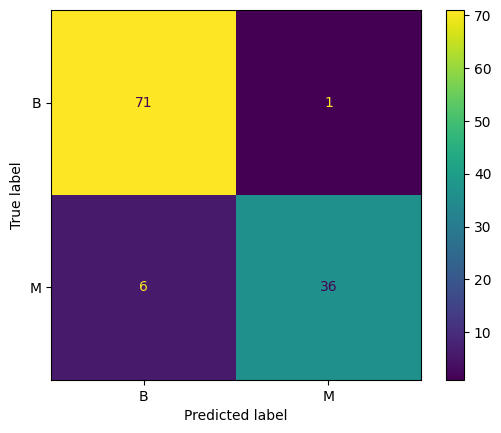

In [92]:
# Creamos el modelo con los mejores parámetros
tree_best = DecisionTreeClassifier(**best_params, random_state=7)

# Entrenamos el modelo
tree_best.fit(X_train, y_train)

# Predecimos los valores de test
y_hat = tree_best.predict(X_test)
cm = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tree_best.classes_)
disp.plot()

##### 4. Mostrar gráficamente los árboles obtenidos en el punto 2 y 3 y compararlos.

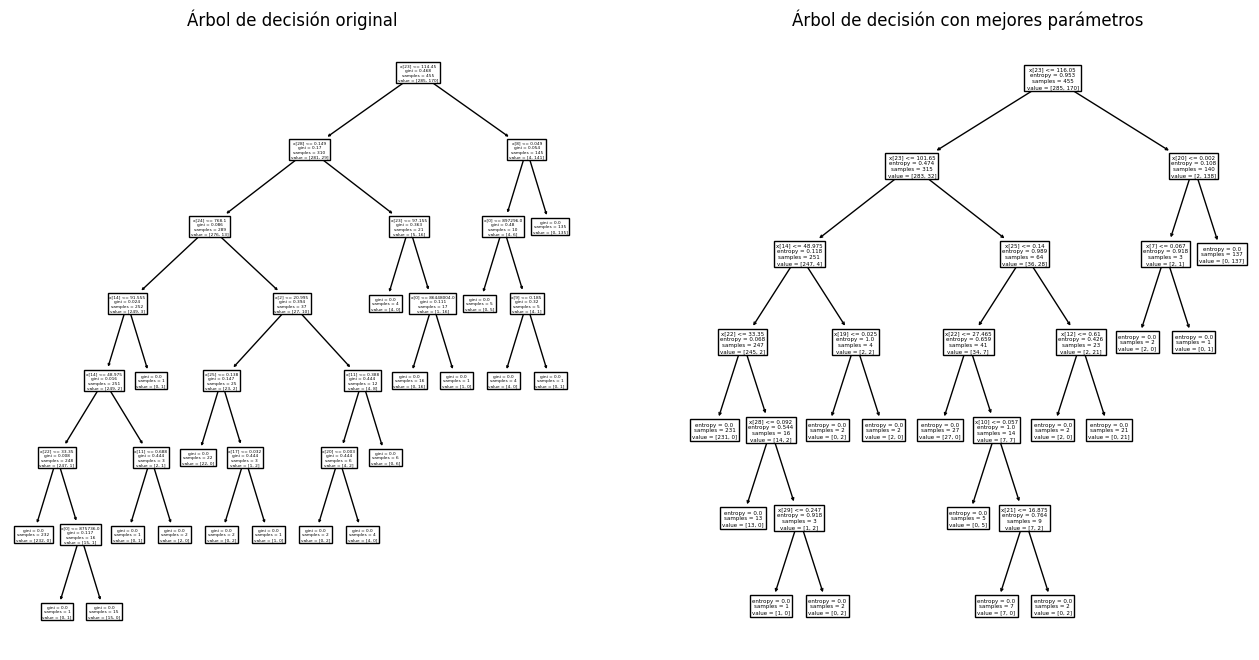

In [93]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))  # Ajustar el tamaño de la figura
plot_tree(tree, ax=ax1)
plot_tree(tree_best, ax=ax2)

ax1.set_title('Árbol de decisión original')  # Añadir título al primer subplot
ax2.set_title('Árbol de decisión con mejores parámetros')  # Añadir título al segundo subplot

plt.show()

Además de ser mejor el arbol con los mejores parámetros, es más sencillo de interpretar, ya que tiene menos nodos y menor profundidad.

### Ejercicio 2: Selección de características con árbol de decisión
La construcción de un árbol de decisión supone seleccionar en cada nodo la mejor característica para dividir el conjunto de muestras que llega a dicho nodo de forma que se minimice una determinada medida de impureza. Por lo tanto, aquellas características que no se incluyen en el árbol final se pueden suponer que no aportan información para la clasificación. De esta forma, se puede considerar la construcción de un árbol de decisión como un método de selección de características. La clase DecisionTreeClassifier posee el atributo feature_importances_ que da una medida de la importancia de las características en el árbol de decisión generado, siendo 0 si alguna característica no ha sido utilizada.

En este ejercicio se debe:
1. Entrenar un árbol de decisión y determinar qué características forman parte del árbol.
2. Entrenar una máquina de vectores soporte con las características seleccionadas en el paso anterior.
3. Seleccionar el mismo número de características que en el primer paso utilizando la clase SelectKBest y como medida de score la información mutua (mutual_info_classif).
4. Entrenar una máquina de vectores soporte con las características seleccionadas con SelectKBest.
5. Comparar el rendimiento de las dos máquinas de vectores soporte entrenadas en el paso 2 y 4.

##### 1. Entrenar un árbol de decisión y determinar qué características forman parte del árbol.

In [94]:
tree = DecisionTreeClassifier()
tree.fit(df.iloc[:, 2:], df.iloc[:, 1])
feat_imp = tree.feature_importances_

fi_dict = dict()
for idx, val in enumerate(df.columns[2:]):
    if feat_imp[idx] > 0:
        fi_dict[val] = round(feat_imp[idx], 4)

minidf1 = pd.DataFrame(fi_dict, index=['Feature Importance Values']).T
minidf1.sort_values(by='Feature Importance Values', ascending=False)
minidf1

,Feature Importance Values
Mean texture,0.0312
Mean smoothness,0.0070
Mean concavity,0.0088
Mean concave points,0.0318
Standard Error radius,0.0073
Standard Error perimeter,0.0056
Standard Error area,0.0020
Standard Error smoothness,0.0010
Standard Error symmetry,0.0058
Worst radius,0.7012


In [95]:
df2 = df[df.columns[df.columns.isin(fi_dict.keys())]]
df2

,Mean texture,Mean smoothness,Mean concavity,Mean concave points,Standard Error radius,Standard Error perimeter,Standard Error area,Standard Error smoothness,Standard Error symmetry,Worst radius,Worst texture,Worst area,Worst smoothness,Worst concavity,Worst concave points
0,10.38,0.11840,0.30010,0.14710,1.0950,8.589,153.40,0.006399,0.03003,25.380,17.33,2019.0,0.16220,0.7119,0.2654
1,17.77,0.08474,0.08690,0.07017,0.5435,3.398,74.08,0.005225,0.01389,24.990,23.41,1956.0,0.12380,0.2416,0.1860
2,21.25,0.10960,0.19740,0.12790,0.7456,4.585,94.03,0.006150,0.02250,23.570,25.53,1709.0,0.14440,0.4504,0.2430
3,20.38,0.14250,0.24140,0.10520,0.4956,3.445,27.23,0.009110,0.05963,14.910,26.50,567.7,0.20980,0.6869,0.2575
4,14.34,0.10030,0.19800,0.10430,0.7572,5.438,94.44,0.011490,0.01756,22.540,16.67,1575.0,0.13740,0.4000,0.1625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,22.39,0.11100,0.24390,0.13890,1.1760,7.673,158.70,0.010300,0.01114,25.450,26.40,2027.0,0.14100,0.4107,0.2216
565,28.25,0.09780,0.14400,0.09791,0.7655,5.203,99.04,0.005769,0.01898,23.690,38.25,1731.0,0.11660,0.3215,0.1628
566,28.08,0.08455,0.09251,0.05302,0.4564,3.425,48.55,0.005903,0.01318,18.980,34.12,1124.0,0.11390,0.3403,0.1418
567,29.33,0.11780,0.35140,0.15200,0.7260,5.772,86.22,0.006522,0.02324,25.740,39.42,1821.0,0.16500,0.9387,0.2650


##### 2. Entrenar una máquina de vectores soporte con las características seleccionadas en el paso anterior.

In [96]:
svc = SVC()
svc.fit(df2, df.iloc[:, 1])

SVC()

##### 3. Seleccionar el mismo número de características que en el primer paso utilizando la clase SelectKBest y como medida de score la información mutua (mutual_info_classif).

In [97]:
k = df2.shape[1]
kbeast = SelectKBest(mutual_info_classif, k=k)
kbeast.fit(df.iloc[:, 2:], df.iloc[:, 1])
scores = kbeast.scores_
scores

array([0.36932075, 0.0968924 , 0.40338153, 0.35946961, 0.08265705,
       0.21165236, 0.37364815, 0.44114585, 0.06219456, 0.00739594,
       0.2469923 , 0.00061677, 0.27778728, 0.33910781, 0.0140262 ,
       0.07576718, 0.11701902, 0.12352746, 0.01502095, 0.0386272 ,
       0.4526274 , 0.12132507, 0.47494056, 0.46543267, 0.0908157 ,
       0.22441295, 0.3140771 , 0.4357678 , 0.08449408, 0.06779187])

In [98]:
kbeast_dict = dict()
for idx, val in enumerate(df.columns[2:]):
    if scores[idx] > 0:
        kbeast_dict[val] = round(scores[idx], 4)

minidf2 = pd.DataFrame(kbeast_dict, index=['Mutual Information Values']).T
minidf2.sort_values(by='Mutual Information Values', ascending=False)
minidf2

,Mutual Information Values
Mean radius,0.3693
Mean texture,0.0969
Mean perimeter,0.4034
Mean area,0.3595
Mean smoothness,0.0827
Mean compactness,0.2117
Mean concavity,0.3736
Mean concave points,0.4411
Mean symmetry,0.0622
Mean fractal dimension,0.0074


In [99]:
df3 = df[df.columns[df.columns.isin(kbeast_dict.keys())]]
df3

,Mean radius,Mean texture,Mean perimeter,Mean area,Mean smoothness,Mean compactness,Mean concavity,Mean concave points,Mean symmetry,Mean fractal dimension,...,Worst radius,Worst texture,Worst perimeter,Worst area,Worst smoothness,Worst compactness,Worst concavity,Worst concave points,Worst symmetry,Worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


##### 4. Entrenar una máquina de vectores soporte con las características seleccionadas con SelectKBest.

In [100]:
svc2 = SVC()
svc2.fit(df3, df.iloc[:, 1])

SVC()

##### 5. Comparar el rendimiento de las dos máquinas de vectores soporte entrenadas en el paso 2 y 4.

In [101]:
accuracy = accuracy_score(df.iloc[:, 1], svc.predict(df2))
print(f'Accuracy Score para SVC con mejores características seleccionadas por el árbol: {accuracy:.4f}%')

accuracy2 = accuracy_score(df.iloc[:, 1], svc2.predict(df3))
print(f'Accuracy Score para SVC con mejores características seleccionadas por KBest: {accuracy2:.4f}%')

Accuracy Score para SVC con mejores características seleccionadas por el árbol: 0.9209%
Accuracy Score para SVC con mejores características seleccionadas por KBest: 0.9227%


La precisión del modelo del apartado 4 es ligeramente superiorar a la precisión del modelo del apartado 2. Lo que sugiere que el modelo entrenado con el método SelectKBest, escoge características es más informativas que el modelo del arbol de decisión.